# Image segmentation with a U-Net-like architecture




<!-- **Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset. -->

## Download the data

In [9]:
!wget http://download.fz-juelich.de/ibg-2/Plant_Phenotyping_Datasets.zip

--2021-04-30 01:44:40--  http://download.fz-juelich.de/ibg-2/Plant_Phenotyping_Datasets.zip
Resolving download.fz-juelich.de (download.fz-juelich.de)... 134.94.130.103
Connecting to download.fz-juelich.de (download.fz-juelich.de)|134.94.130.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195344019 (1.1G) [application/zip]
Saving to: ‘Plant_Phenotyping_Datasets.zip’

Plant_Phenotyping_D 100%[===================>]   1.11G  24.1MB/s    in 56s     

2021-04-30 01:45:37 (20.3 MB/s) - ‘Plant_Phenotyping_Datasets.zip’ saved [1195344019/1195344019]



In [12]:
!unzip Plant_Phenotyping_Datasets.zip 

Archive:  Plant_Phenotyping_Datasets.zip
   creating: Plant_Phenotyping_Datasets/
   creating: Plant_Phenotyping_Datasets/Plant/
   creating: Plant_Phenotyping_Datasets/Plant/Ara2012/
  inflating: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant001_bbox.csv  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant001_boundaries.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant001_centers.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant001_label.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant001_rgb.png  
  inflating: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant002_bbox.csv  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant002_boundaries.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant002_centers.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara2012_plant002_label.png  
 extracting: Plant_Phenotyping_Datasets/Plant/Ara2012/ara20

In [22]:

!mv labels/ara2012_plant*_rgb.png images/

mkdir: cannot create directory ‘images’: File exists


In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  29.9M      0  0:00:25  0:00:25 --:--:-- 31.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  10.6M      0  0:00:01  0:00:01 --:--:-- 10.6M


## Prepare paths of input images and target segmentation masks

In [24]:
import os

input_dir = "images/"
target_dir = "labels/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 120
images/ara2012_plant001_rgb.png | labels/ara2012_plant001_label.png
images/ara2012_plant002_rgb.png | labels/ara2012_plant002_label.png
images/ara2012_plant003_rgb.png | labels/ara2012_plant003_label.png
images/ara2012_plant004_rgb.png | labels/ara2012_plant004_label.png
images/ara2012_plant005_rgb.png | labels/ara2012_plant005_label.png
images/ara2012_plant006_rgb.png | labels/ara2012_plant006_label.png
images/ara2012_plant007_rgb.png | labels/ara2012_plant007_label.png
images/ara2012_plant008_rgb.png | labels/ara2012_plant008_label.png
images/ara2012_plant009_rgb.png | labels/ara2012_plant009_label.png
images/ara2012_plant010_rgb.png | labels/ara2012_plant010_label.png


## What does one input image and corresponding segmentation mask look like?

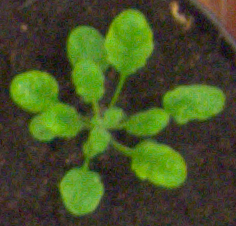

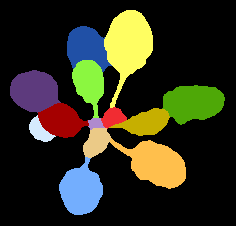

In [25]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [31]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Prepare U-Net Xception-style model

In [32]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [33]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [34]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15


ValueError: ignored

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.